# BBRL Documentation: the interaction loop

## Outlook

In this notebook, we introduce the conceptual model behind BBRL, which is inherited from SaLinA. We present the model of the interaction loop, to compare with the Stable Baseline 3 approach, which is described in detail in [another notebook](https://colab.research.google.com/drive/1sBZLs-GaM8Xx7MsF6sUH7LIj6GwCq5VW?usp=sharing).


This notebook is the main entry point to the BBRL documentation. Below we point the reader to other elements of the documentation.
But the BBRL approach can also be learned through practicing, by rather following the practical track, which starts in [this notebook](https://colab.research.google.com/drive/1gSdkOBPkIQi_my9TtwJ-qWZQS0b2X7jt?usp=sharing) where the interaction loop is implemented.

## What is BBRL ?

BBRL stands for "BlackBoard Reinforcement Learning". Initially, [the BBRL library](https://github.com/osigaud/bbrl) was a fork of [the SaLinA library](https://github.com/facebookresearch/salina). But SaLinA is a general model for sequential learning whereas BBRL is dedicated to RL, thus it focuses on a subset of SaLinA. Morevover, BBRL is designed for education purpose (in particular, to teach various RL algorithms, concepts and phenomena). Thus the fork slowly drifted away from SaLinA and became independent after a few months, even if some parts of the code are still inherited from SaLinA.



But the conceptual approach is the same. The general idea is to represent everything as **agents** interacting into a **workspace**, which is similar to the **blackboard** approach in multiagent systems (hence the name of the library).

## The core interaction loop

The figure below is the standard figure to present the interaction between an agent and its environment in RL. 

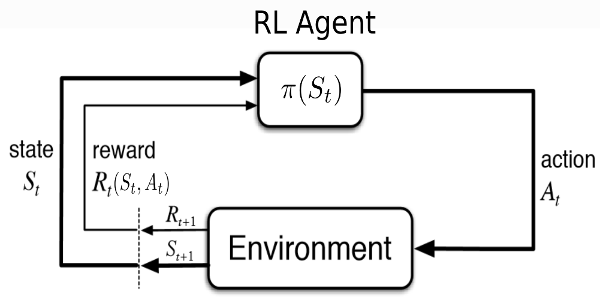

In Stable Baseline 3, this interaction loop is a central piece of code which is equipped with hooks to be able to apply callbacks and where you can put wrappers around the environment (again, see the notebook mentioned above).

In BBRL, the model is completely different. It is implemented as a **workspace** where several agents are reading and writing information. This is depicted in the figure below.

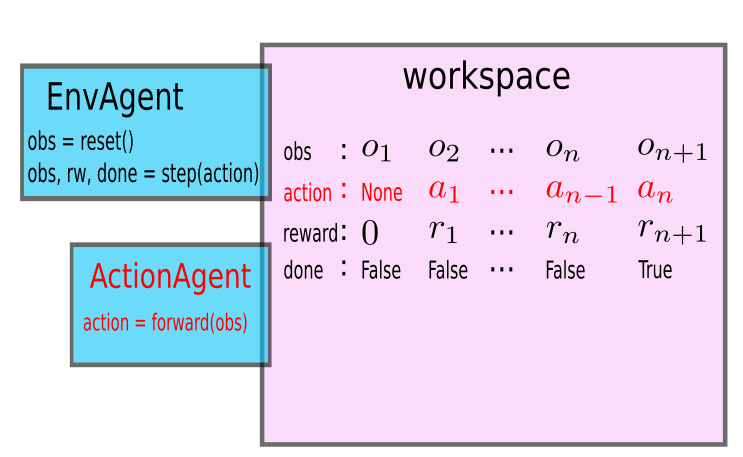

Everything interacting in a workspace is an Agent, so in BBRL the environment is an Agent too. We may call it the EnvAgent and if we are running a gym environment, this agent must be capable of calling `reset()` and `step()` following the gym interface, but these calls are hidden into the code of the generic GymAgent [here](https://github.com/osigaud/bbrl/blob/master/bbrl/agents/gyma.py) that an EnvAgent should inherit from. Similarly, we may call the standard RL agent the ActionAgent, it must be capable to send an action to the gym agent, but the BBRL code takes this in charge in the Agent class [here](https://github.com/osigaud/bbrl/blob/master/bbrl/agents/agent.py).

# Workspace

Conceptually, the workspace is a space where agents interact. In practice, it is implemented as a dictionary of Tensors that temporal agents can write into (or read from). 

The implementation of BBRL workspaces is available [here](https://github.com/osigaud/bbrl/blob/master/bbrl/workspace.py). The tensors written in the workspace can have a fixed size (for computational efficiency) or not and can be in shared memory in the case of multiprocessing or not.



Note also that when using gradient descent techniques from pytorch over data stored into workspaces, some gradient information can be attached through computation graphs to the stored tensors. All these gradient informations can be removed by applying `workspace.zero_grad()` as you would do for a single tensor.

# Agents

Agents are the entities interacting into a workspace. In practice, all agents used in BBRL are temporal agents, from the class ```BBRL.agents.TemporalAgent```. In practice, a temporal agent contains an inner agent which can be for instance an environment agent or an action agent, and calling the temporal agent with a workspace in parameter will call the agent inside the workspace at each time step for a number of steps or until a termination condition is fulfilled.

Each agent has its own labels for the variables it is writing with `set(label, value)` and can read other variables with `value = get(label)`.

# GymAgents: AutoReset or NoAutoReset?

As mentioned above, in BBRL the environment is an agent, inheriting from a GymAgent. A key feature of BBRL is that it supports training and evaluating agents over several instances of the same environment at the same time.

This feature is important for RL, as most deep RL algorithms are more stable when the learning agent is trained from multiple environments, but is raises some issues.

In particular, if an agent is running episodes over several environments and an episode in an environment stops before the others, what should the algorithm do:
- freeze learning in this environment until all episodes are finished in all other environments? This can be a huge waste of time and computational resources?
- or restart the agent in this environment, and desynchronize episodes in the various environments?

The first solution is simpler, it is implemented with the NoAutoResetGymAgent, and explained in detail in [this notebook](https://colab.research.google.com/drive/1EX5O03mmWFp9wCL_Gb_-p08JktfiL2l5?usp=sharing).

The second solution is more complex and raises additional issues, it is implemented with the AutoResetGymAgent and explained in detail in [this notebook](https://colab.research.google.com/drive/1W9Y-3fa6LsPeR6cBC1vgwBjKfgMwZvP5?usp=sharing).

# Reward indexing

Two ways to index rewards in an RL process coexist in the literature. BBRL covers both ways of dealing with rewards, this is explained in detail in [this notebook](https://colab.research.google.com/drive/1Cld72_FBA1aMS2U4EsyV3LGZIlQC_PsC?usp=sharing).

# Dealing with time limits

Most RL problems are episodic: at some point, the episode stops and the learning agent is eventually reset somewhere else. One condition for stopping an episode can be that a time limit has been reached. This case is known in the literature to raise some consistency issues. This is explained in [this notebook](https://colab.research.google.com/drive/1erLbRKvdkdDy0Zn1X_JhC01s1QAt4BBj?usp=sharing) together with the way BBRL deals with the issue.